In [1]:
# Importing Packages
import numpy as np
import pandas as pd; print(pd.__version__)


import matplotlib.gridspec as gridspec
import itertools
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix as conMatrix
from sklearn.metrics import classification_report as ClassR
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

%matplotlib inline

1.4.1


In [2]:
# Importing datasets
train_df = pd.read_csv('Airbnb-train.csv')
test_df = pd.read_csv('Airbnb-test.csv')

In [3]:
train_df.info

<bound method DataFrame.info of              id  log_price property_type        room_type  \
0       6901257   5.010635     Apartment  Entire home/apt   
1       6304928   5.129899     Apartment  Entire home/apt   
2       7919400   4.976734     Apartment  Entire home/apt   
3      13418779   6.620073         House  Entire home/apt   
4       3808709   4.744932     Apartment  Entire home/apt   
...         ...        ...           ...              ...   
74106  14549287   4.605170     Apartment     Private room   
74107  13281809   5.043425     Apartment  Entire home/apt   
74108  18688039   5.220356     Apartment  Entire home/apt   
74109  17045948   5.273000     Apartment  Entire home/apt   
74110   3534845   4.852030          Boat  Entire home/apt   

                                               amenities  accommodates  \
0      {"Wireless Internet","Air conditioning",Kitche...             3   
1      {"Wireless Internet","Air conditioning",Kitche...             7   
2      {TV,"C

In [4]:
train_df.head()
train_df.shape

(74111, 29)

In [5]:
train_df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


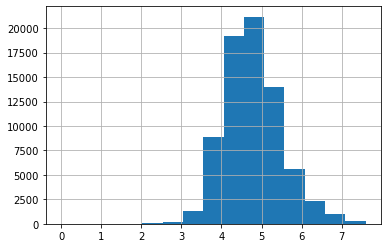

In [6]:
# Looking at distribution of log_price as this is the variable that we want to predict
logprice_df = train_df["log_price"]
logprice_hist = logprice_df.hist(bins=15)

In [7]:
#Data pre-processing to determine what features to select for these models
train_df.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

In [8]:
# dropping the unused columns and columns that will be difficult to enumerate. Mostly the review dates and location information as I will only be using the city names for location purposes.
train_df = train_df.drop(['id', 'amenities', 'description', 'first_review', 'host_response_rate', 'host_since', 'last_review', 'latitude', 'longitude', 'zipcode', 'name', 'thumbnail_url'], axis=1)
test_df = test_df.drop(['id', 'amenities', 'description', 'first_review', 'host_response_rate', 'host_since', 'last_review', 'latitude', 'longitude', 'zipcode', 'name', 'thumbnail_url'], axis=1)

In [9]:
#Looking at missing values for each column
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
15,bedrooms,91
16,beds,131
9,host_has_profile_pic,188
10,host_identity_verified,188
4,bathrooms,200
12,neighbourhood,6872
14,review_scores_rating,16722


In [10]:
# Setting Bathrooms, Bedrooms and Beds default to 0
train_df['bathrooms'] = train_df['bathrooms'].fillna(0)
test_df['bathrooms'] = test_df['bathrooms'].fillna(0)

train_df['bedrooms'] = train_df['bedrooms'].fillna(0)
test_df['bedrooms'] = test_df['bedrooms'].fillna(0)

train_df['beds'] = train_df['beds'].fillna(0)
test_df['beds'] = test_df['beds'].fillna(0)

# setting host_has_profile_pic and host_identity_verified to default False (f)
train_df['host_has_profile_pic'] = train_df['host_has_profile_pic'].fillna(0)
test_df['host_has_profile_pic'] = test_df['host_has_profile_pic'].fillna(0)

train_df['host_identity_verified'] = train_df['host_identity_verified'].fillna(0)
test_df['host_identity_verified'] = test_df['host_identity_verified'].fillna(0)

# dropping na's from neighbourhood column
train_df = train_df.dropna(subset = ['neighbourhood'])
test_df = test_df.dropna(subset = ['neighbourhood'])


# dropping na's from review_scores_rating to not skew the data for scores
train_df = train_df.dropna(subset = ['review_scores_rating'])
test_df = test_df.dropna(subset = ['review_scores_rating'])

In [11]:
# checking missing values after all the changes
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [12]:
# Enumerating the rest of our values
# cleaning fee
train_df.loc[train_df.cleaning_fee == 'True', 'cleaning_fee'] = 1
train_df.loc[train_df.cleaning_fee == 'False', 'cleaning_fee'] = 0
test_df.loc[test_df.cleaning_fee == 'True', 'cleaning_fee'] = 1
test_df.loc[test_df.cleaning_fee == 'False', 'cleaning_fee'] = 0
train_df['cleaning_fee'] = train_df['cleaning_fee'].astype("bool")
test_df['cleaning_fee'] = test_df['cleaning_fee'].astype("bool")

# host has profile pic
train_df.loc[train_df.host_has_profile_pic == 't', 'host_has_profile_pic'] = 1
train_df.loc[train_df.host_has_profile_pic == 'f', 'host_has_profile_pic'] = 0
test_df.loc[test_df.host_has_profile_pic == 't', 'host_has_profile_pic'] = 1
test_df.loc[test_df.host_has_profile_pic == 'f', 'host_has_profile_pic'] = 0
train_df['host_has_profile_pic'] = train_df['host_has_profile_pic'].astype("bool")
test_df['host_has_profile_pic'] = test_df['host_has_profile_pic'].astype("bool")

# host identity verified
train_df.loc[train_df.host_identity_verified == 't', 'host_identity_verified'] = 1
train_df.loc[train_df.host_identity_verified == 'f', 'host_identity_verified'] = 0
test_df.loc[test_df.host_identity_verified == 't', 'host_identity_verified'] = 1
test_df.loc[test_df.host_identity_verified == 'f', 'host_identity_verified'] = 0
train_df['host_identity_verified'] = train_df['host_identity_verified'].astype("bool")
test_df['host_identity_verified'] = test_df['host_identity_verified'].astype("bool")

# instant bookable
train_df.loc[train_df.instant_bookable == 't', 'instant_bookable'] = 1
train_df.loc[train_df.instant_bookable == 'f', 'instant_bookable'] = 0
test_df.loc[test_df.instant_bookable == 't', 'instant_bookable'] = 1
test_df.loc[test_df.instant_bookable == 'f', 'instant_bookable'] = 0
train_df['instant_bookable'] = train_df['instant_bookable'].astype("bool")
test_df['instant_bookable'] = test_df['instant_bookable'].astype("bool")

In [13]:
# We need to use label encoding to enumerate the categorical features
# First have to change type to category
train_df['neighbourhood'] = train_df['neighbourhood'].astype("category")
test_df['neighbourhood'] = test_df['neighbourhood'].astype("category")

train_df['room_type'] = train_df['room_type'].astype("category")
test_df['room_type'] = test_df['room_type'].astype("category")

train_df['property_type'] = train_df['property_type'].astype("category")
test_df['property_type'] = test_df['property_type'].astype("category")

train_df['bed_type'] = train_df['bed_type'].astype("category")
test_df['bed_type'] = test_df['bed_type'].astype("category")

train_df['city'] = train_df['city'].astype("category")
test_df['city'] = test_df['city'].astype("category")

train_df['cancellation_policy'] = train_df['cancellation_policy'].astype("category")
test_df['cancellation_policy'] = test_df['cancellation_policy'].astype("category")

In [14]:
train_df.dtypes

log_price                  float64
property_type             category
room_type                 category
accommodates                 int64
bathrooms                  float64
bed_type                  category
cancellation_policy       category
cleaning_fee                  bool
city                      category
host_has_profile_pic          bool
host_identity_verified        bool
instant_bookable              bool
neighbourhood             category
number_of_reviews            int64
review_scores_rating       float64
bedrooms                   float64
beds                       float64
dtype: object

In [15]:
# Creating label codes for each categorical variable
train_df['neighbourhood'] = train_df['neighbourhood'].cat.codes
test_df['neighbourhood'] = test_df['neighbourhood'].cat.codes

train_df['room_type'] = train_df['room_type'].cat.codes
test_df['room_type'] = test_df['room_type'].cat.codes

train_df['property_type'] = train_df['property_type'].cat.codes
test_df['property_type'] = test_df['property_type'].cat.codes

train_df['bed_type'] = train_df['bed_type'].cat.codes
test_df['bed_type'] = test_df['bed_type'].cat.codes

train_df['city'] = train_df['city'].cat.codes
test_df['city'] = test_df['city'].cat.codes

train_df['cancellation_policy'] = train_df['cancellation_policy'].cat.codes
test_df['cancellation_policy'] = test_df['cancellation_policy'].cat.codes

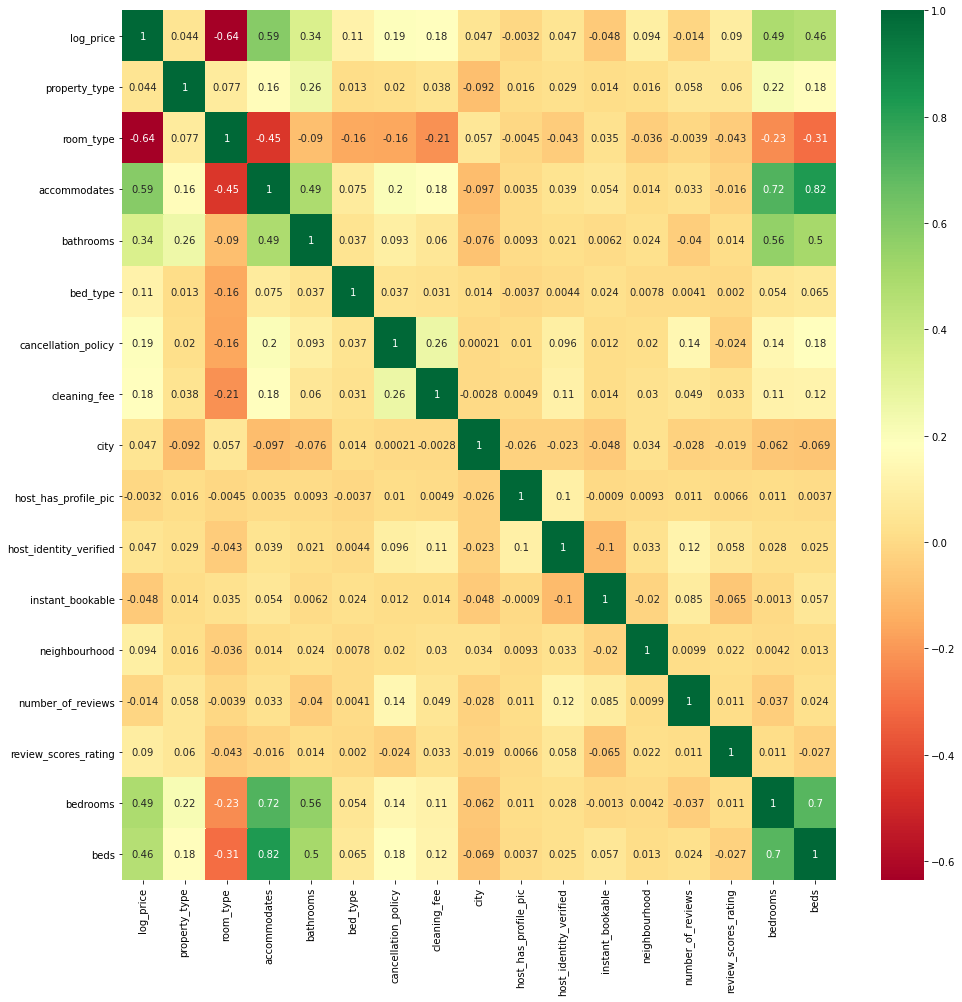

In [16]:
# Correlation Heatmap for train_df
X = train_df.iloc[:,1:29]  #independent columns
y = train_df.iloc[:,0]    #target column
#get correlations of each features in dataset
import matplotlib.pyplot as plt
corrmat = train_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(16,16))
#plot heat map
g=sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [95]:
# binning log_price for classification Equal Bin width
cut_labels = [1,2,3,4]
train_df['price_bins'] = pd.cut(train_df['log_price'], bins=4, labels=cut_labels)
test_df['price_bins'] = pd.cut(train_df['log_price'], bins=4, labels=cut_labels)

In [18]:
# binning log_price for classification Equal frequency bins
qcut_labels = [1,2,3,4]
train_df['price_bins'] = pd.qcut(train_df['log_price'], q=4, labels=qcut_labels)
test_df['price_bins'] = pd.qcut(train_df['log_price'], q=4, labels=qcut_labels)

In [96]:
train_df.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds,price_bins
0,5.010635,0,0,3,1.0,4,2,True,4,True,True,False,73,2,100.0,1.0,1.0,3
1,5.129899,0,0,7,1.0,4,2,True,4,True,False,True,241,6,93.0,3.0,3.0,3
2,4.976734,0,0,5,1.0,4,1,True,4,True,True,True,237,10,92.0,1.0,3.0,3
4,4.744932,0,0,2,1.0,4,1,True,2,True,True,True,112,4,40.0,0.0,1.0,3
5,4.442651,0,1,2,1.0,4,2,True,5,True,True,True,374,3,100.0,1.0,1.0,3


[0.04648089 0.05292506 0.12528293 0.09884167 0.00911338 0.03464794
 0.01082334 0.06735195 0.00139689 0.01774818 0.01599328 0.17138863
 0.15402823 0.11636476 0.07761288]


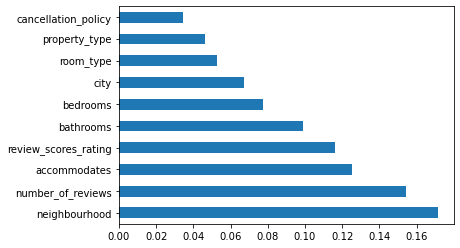

In [97]:
# Feature Importance using Tree Based Classifier 
X = train_df.iloc[:,1:16]  #independent columns
y = train_df.iloc[:,-1]    #target column
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [98]:
#Univariate Selection using SelectKBest

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = train_df.iloc[:,1:16]  #independent columns
y = train_df.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score')) 

                   Specs         Score
2           accommodates  17206.796794
11         neighbourhood  16795.890494
12     number_of_reviews  16738.657670
0          property_type  13441.234996
14              bedrooms   7102.275525
1              room_type   5135.090195
3              bathrooms   2469.208183
5    cancellation_policy    428.453642
13  review_scores_rating    142.293518
6           cleaning_fee    138.763975


In [99]:
# dropping features to create top 10 dataframe
train10 = train_df.drop(['host_has_profile_pic','bed_type','cleaning_fee','instant_bookable','host_identity_verified'], axis=1)

train10.head()

,log_price,property_type,room_type,accommodates,bathrooms,cancellation_policy,city,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds,price_bins
0,5.010635,0,0,3,1.0,2,4,73,2,100.0,1.0,1.0,3
1,5.129899,0,0,7,1.0,2,4,241,6,93.0,3.0,3.0,3
2,4.976734,0,0,5,1.0,1,4,237,10,92.0,1.0,3.0,3
4,4.744932,0,0,2,1.0,1,2,112,4,40.0,0.0,1.0,3
5,4.442651,0,1,2,1.0,2,5,374,3,100.0,1.0,1.0,3


In [100]:
# Training the decision tree
X = train_df.iloc[:,1:16]
y = train_df.iloc[:,-1]

from sklearn.tree import DecisionTreeClassifier as dtc # tree algorithm
from sklearn.model_selection import train_test_split # splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [101]:
# Creating DT using entropy and max depth of 5
model = dtc(criterion = 'entropy', max_depth = 5)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [102]:
y_pred = model.predict(X_test)

In [103]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0    0    1    0]
 [   0   69  469    2]
 [   0   51 8836  165]
 [   0    2  539  335]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.57      0.13      0.21       540
           3       0.90      0.98      0.94      9052
           4       0.67      0.38      0.49       876

    accuracy                           0.88     10469
   macro avg       0.53      0.37      0.41     10469
weighted avg       0.86      0.88      0.86     10469



C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
model = dtc(criterion = 'entropy', max_depth = 10)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [105]:
y_pred = model.predict(X_test)

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0    0    1    0]
 [   0   81  458    1]
 [   0   54 8771  227]
 [   0    3  466  407]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.59      0.15      0.24       540
           3       0.90      0.97      0.94      9052
           4       0.64      0.46      0.54       876

    accuracy                           0.88     10469
   macro avg       0.53      0.40      0.43     10469
weighted avg       0.87      0.88      0.87     10469



C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
# Training the decision tree for t10
X = train10.iloc[:,1:12]
Y = train10.iloc[:,-1]

from sklearn.tree import DecisionTreeClassifier as dtc # tree algorithm
from sklearn.model_selection import train_test_split # splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [108]:
# Creating DT using entropy and max depth of 5
model = dtc(criterion = 'entropy', max_depth = 5)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [109]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0    0    1    0]
 [   0   57  419    3]
 [   0   41 8827  227]
 [   0    0  502  392]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.58      0.12      0.20       479
           3       0.91      0.97      0.94      9095
           4       0.63      0.44      0.52       894

    accuracy                           0.89     10469
   macro avg       0.53      0.38      0.41     10469
weighted avg       0.87      0.89      0.87     10469



C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
# Creating DT using entropy and max depth of 5
model = dtc(criterion = 'entropy', max_depth = 10)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [111]:
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0    0    1    0]
 [   0   58  416    5]
 [   0   60 8795  240]
 [   0    0  483  411]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.49      0.12      0.19       479
           3       0.91      0.97      0.94      9095
           4       0.63      0.46      0.53       894

    accuracy                           0.88     10469
   macro avg       0.51      0.39      0.42     10469
weighted avg       0.86      0.88      0.87     10469



C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
import pandas as pd # data processing
import numpy as np # working with arrays
import matplotlib.pyplot as plt # visualization
from matplotlib import rcParams # figure size
from termcolor import colored as cl # text customization

from sklearn.tree import DecisionTreeClassifier as dtc # tree algorithm
from sklearn.model_selection import train_test_split # splitting the data
from sklearn.metrics import accuracy_score # model precision
from sklearn.tree import plot_tree # tree diagram

X = train10.iloc[:,1:12].values
Y = train10.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
print(cl('X_train shape : {}'.format(X_train.shape)))
print(cl('X_test shape : {}'.format(X_test.shape)))
print(cl('y_train shape : {}'.format(y_train.shape)))
print(cl('y_test shape : {}'.format(y_test.shape)))

X_train shape : (41874, 11)
X_test shape : (10469, 11)
y_train shape : (41874,)
y_test shape : (10469,)


In [113]:
model = dtc(criterion = 'entropy', max_depth = 5)
model.fit(X_train, y_train)

pred_model = model.predict(X_test)

print(cl('Accuracy of the model is {:.0%}'.format(accuracy_score(y_test, pred_model))))

Accuracy of the model is 88%


In [114]:
model = dtc(max_depth = 10, criterion = 'entropy')
model.fit(X_train, y_train)

pred_model = model.predict(X_test)

print(cl('Accuracy of the model is {:.0%}'.format(accuracy_score(y_test, pred_model))))

Accuracy of the model is 88%


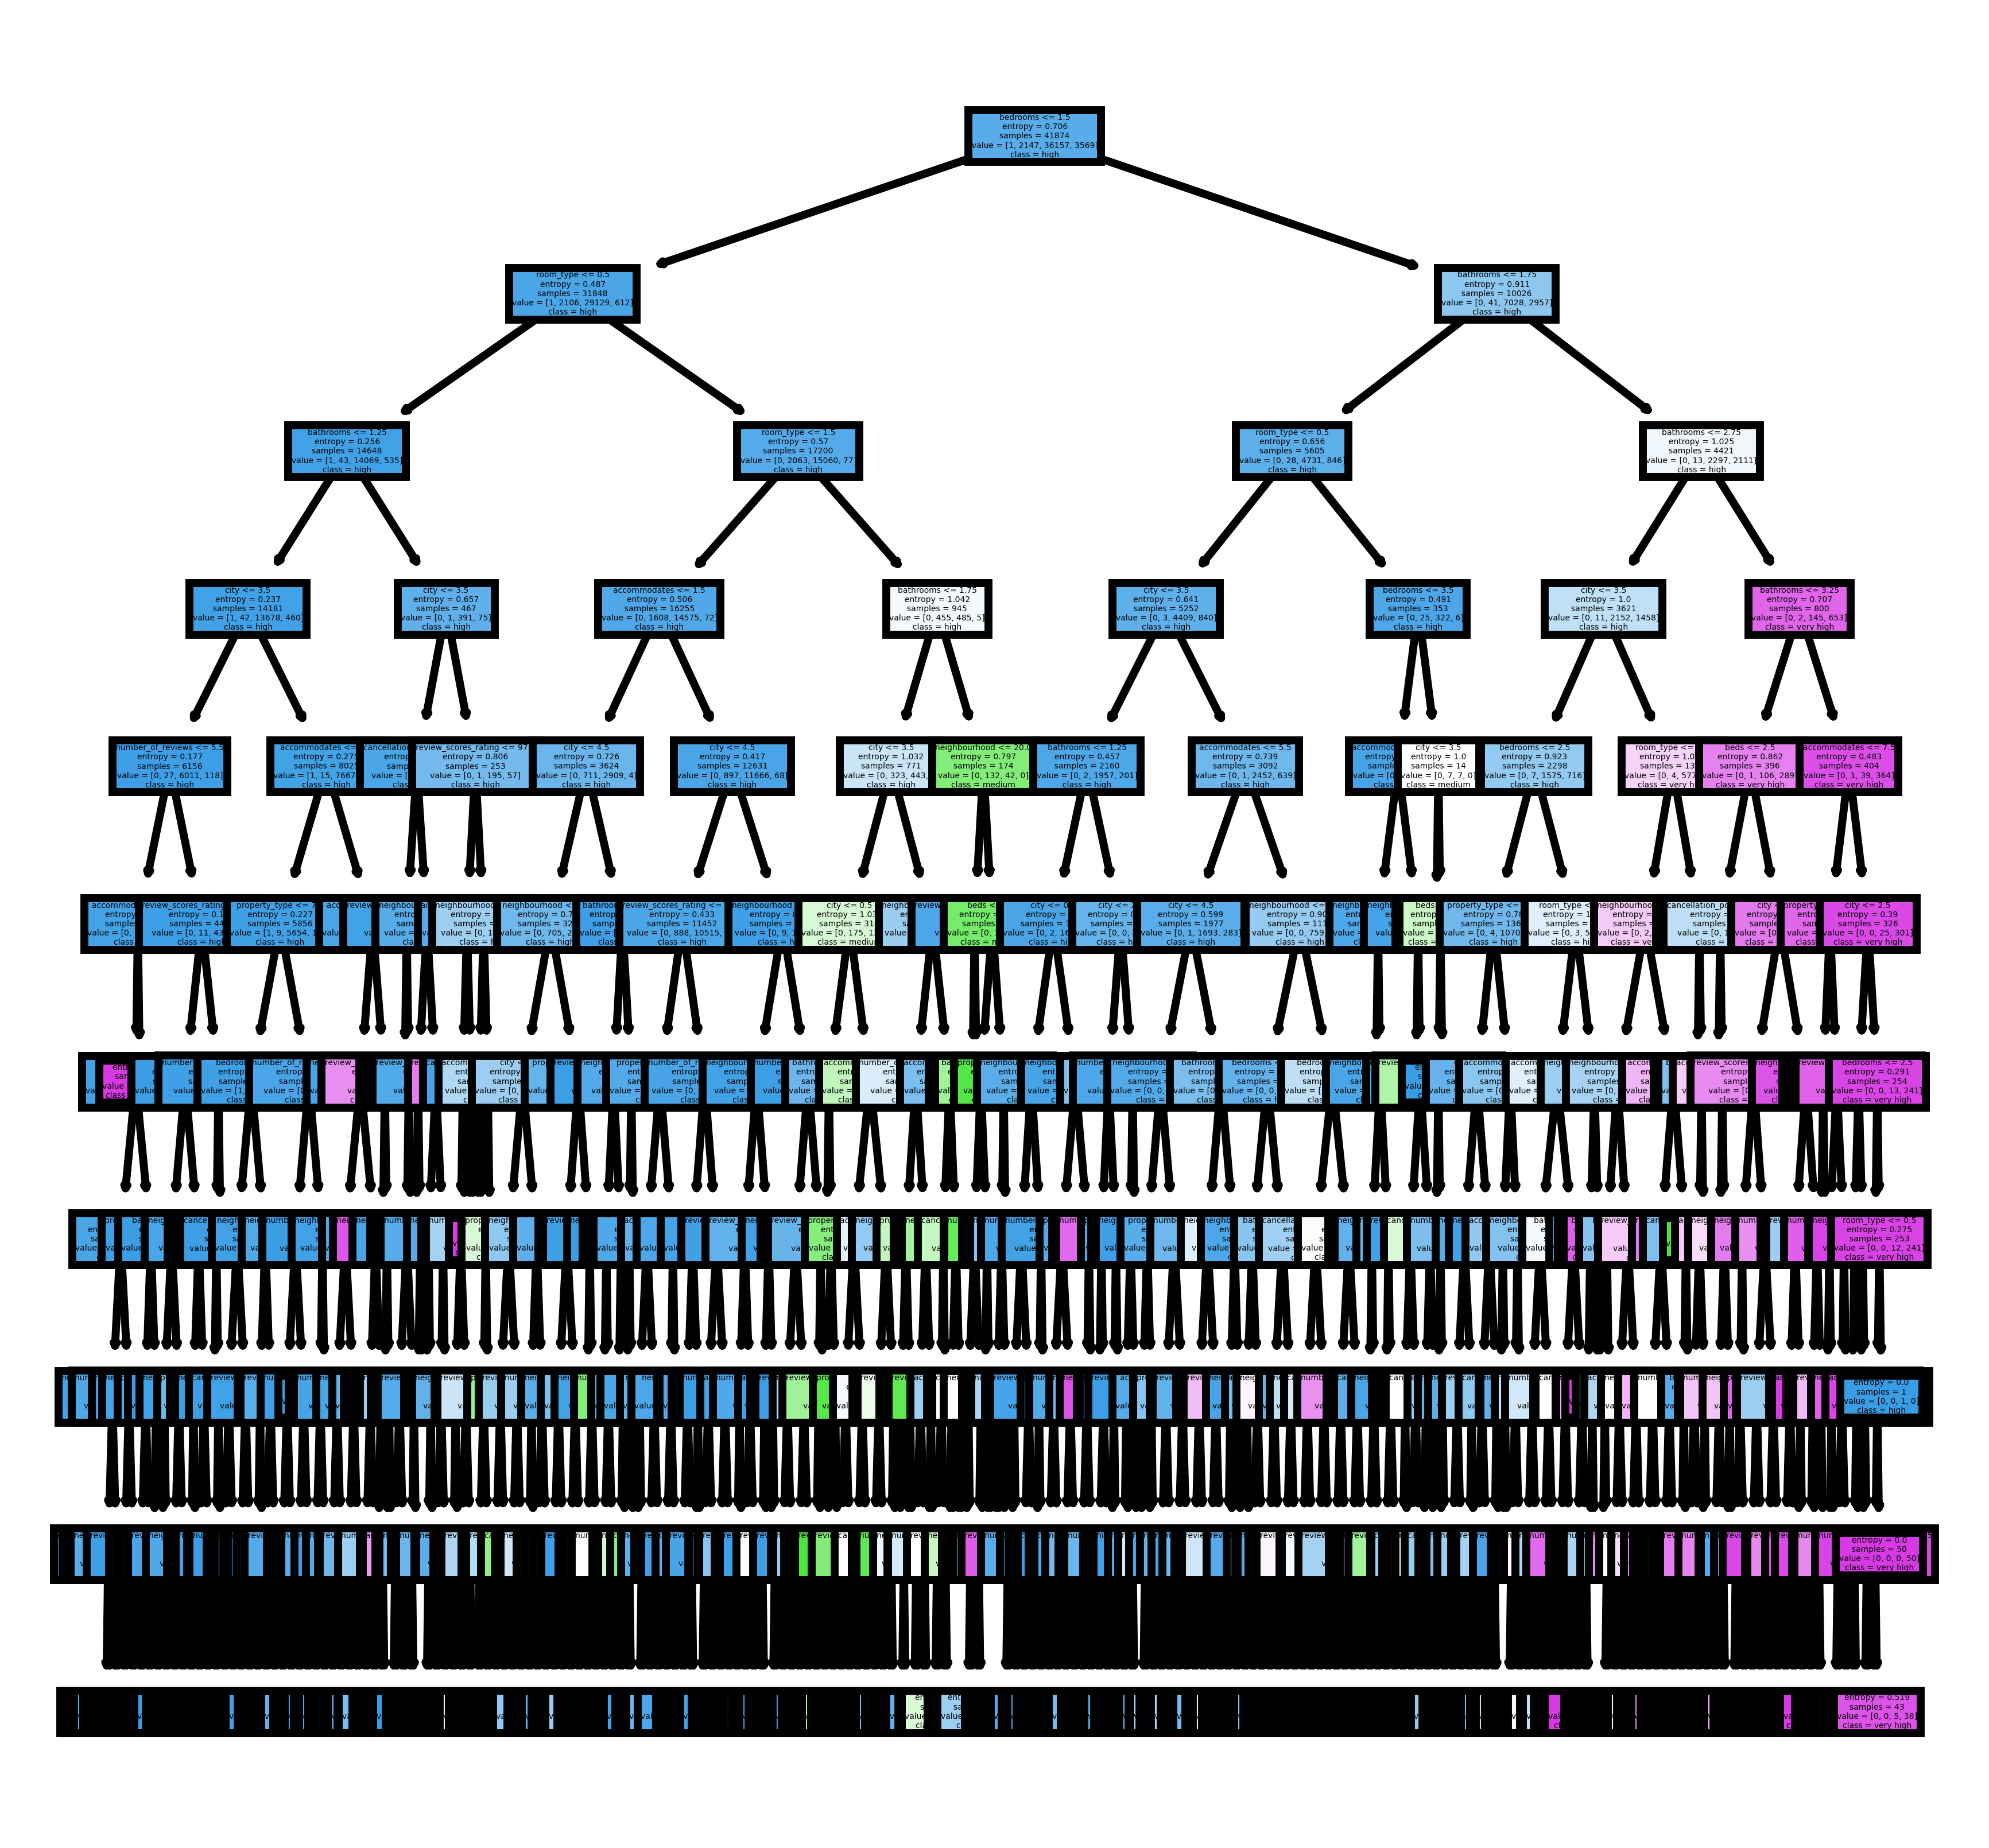

In [115]:
# Create visual tree for train10
from sklearn import tree
fn=['property_type','room_type','accommodates','bathrooms','cancellation_policy','city','neighbourhood','number_of_reviews','review_scores_rating','bedrooms','beds']
cn=['low', 'medium', 'high', 'very high']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1000)
tree.plot_tree(model,
               feature_names = fn, 
               class_names=cn,
               filled = True);
# fig.savefig('imagename6-train10.png')

In [116]:
X = train_df.iloc[:,1:16].values
Y = train_df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
print(cl('X_train shape : {}'.format(X_train.shape)))
print(cl('X_test shape : {}'.format(X_test.shape)))
print(cl('y_train shape : {}'.format(y_train.shape)))
print(cl('y_test shape : {}'.format(y_test.shape)))

X_train shape : (41874, 15)
X_test shape : (10469, 15)
y_train shape : (41874,)
y_test shape : (10469,)


In [117]:
model = dtc(criterion = 'entropy', max_depth = 5)
model.fit(X_train, y_train)

pred_model = model.predict(X_test)

print(cl('Accuracy of the model is {:.0%}'.format(accuracy_score(y_test, pred_model))))

Accuracy of the model is 88%


In [118]:
model = dtc(criterion = 'gini', max_depth = 5)
model.fit(X_train, y_train)

pred_model = model.predict(X_test)

print(cl('Accuracy of the model is {:.0%}'.format(accuracy_score(y_test, pred_model))))

Accuracy of the model is 88%


In [119]:
model = dtc(max_depth = 10, criterion = 'entropy')
model.fit(X_train, y_train)

pred_model = model.predict(X_test)

print(cl('Accuracy of the model is {:.0%}'.format(accuracy_score(y_test, pred_model))))

Accuracy of the model is 88%


In [120]:
model = dtc(max_depth = 10, criterion = 'gini')
model.fit(X_train, y_train)

pred_model = model.predict(X_test)

print(cl('Accuracy of the model is {:.0%}'.format(accuracy_score(y_test, pred_model))))

Accuracy of the model is 88%


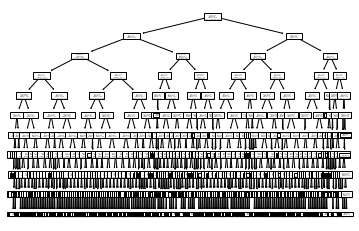

In [121]:
tree.plot_tree(model);

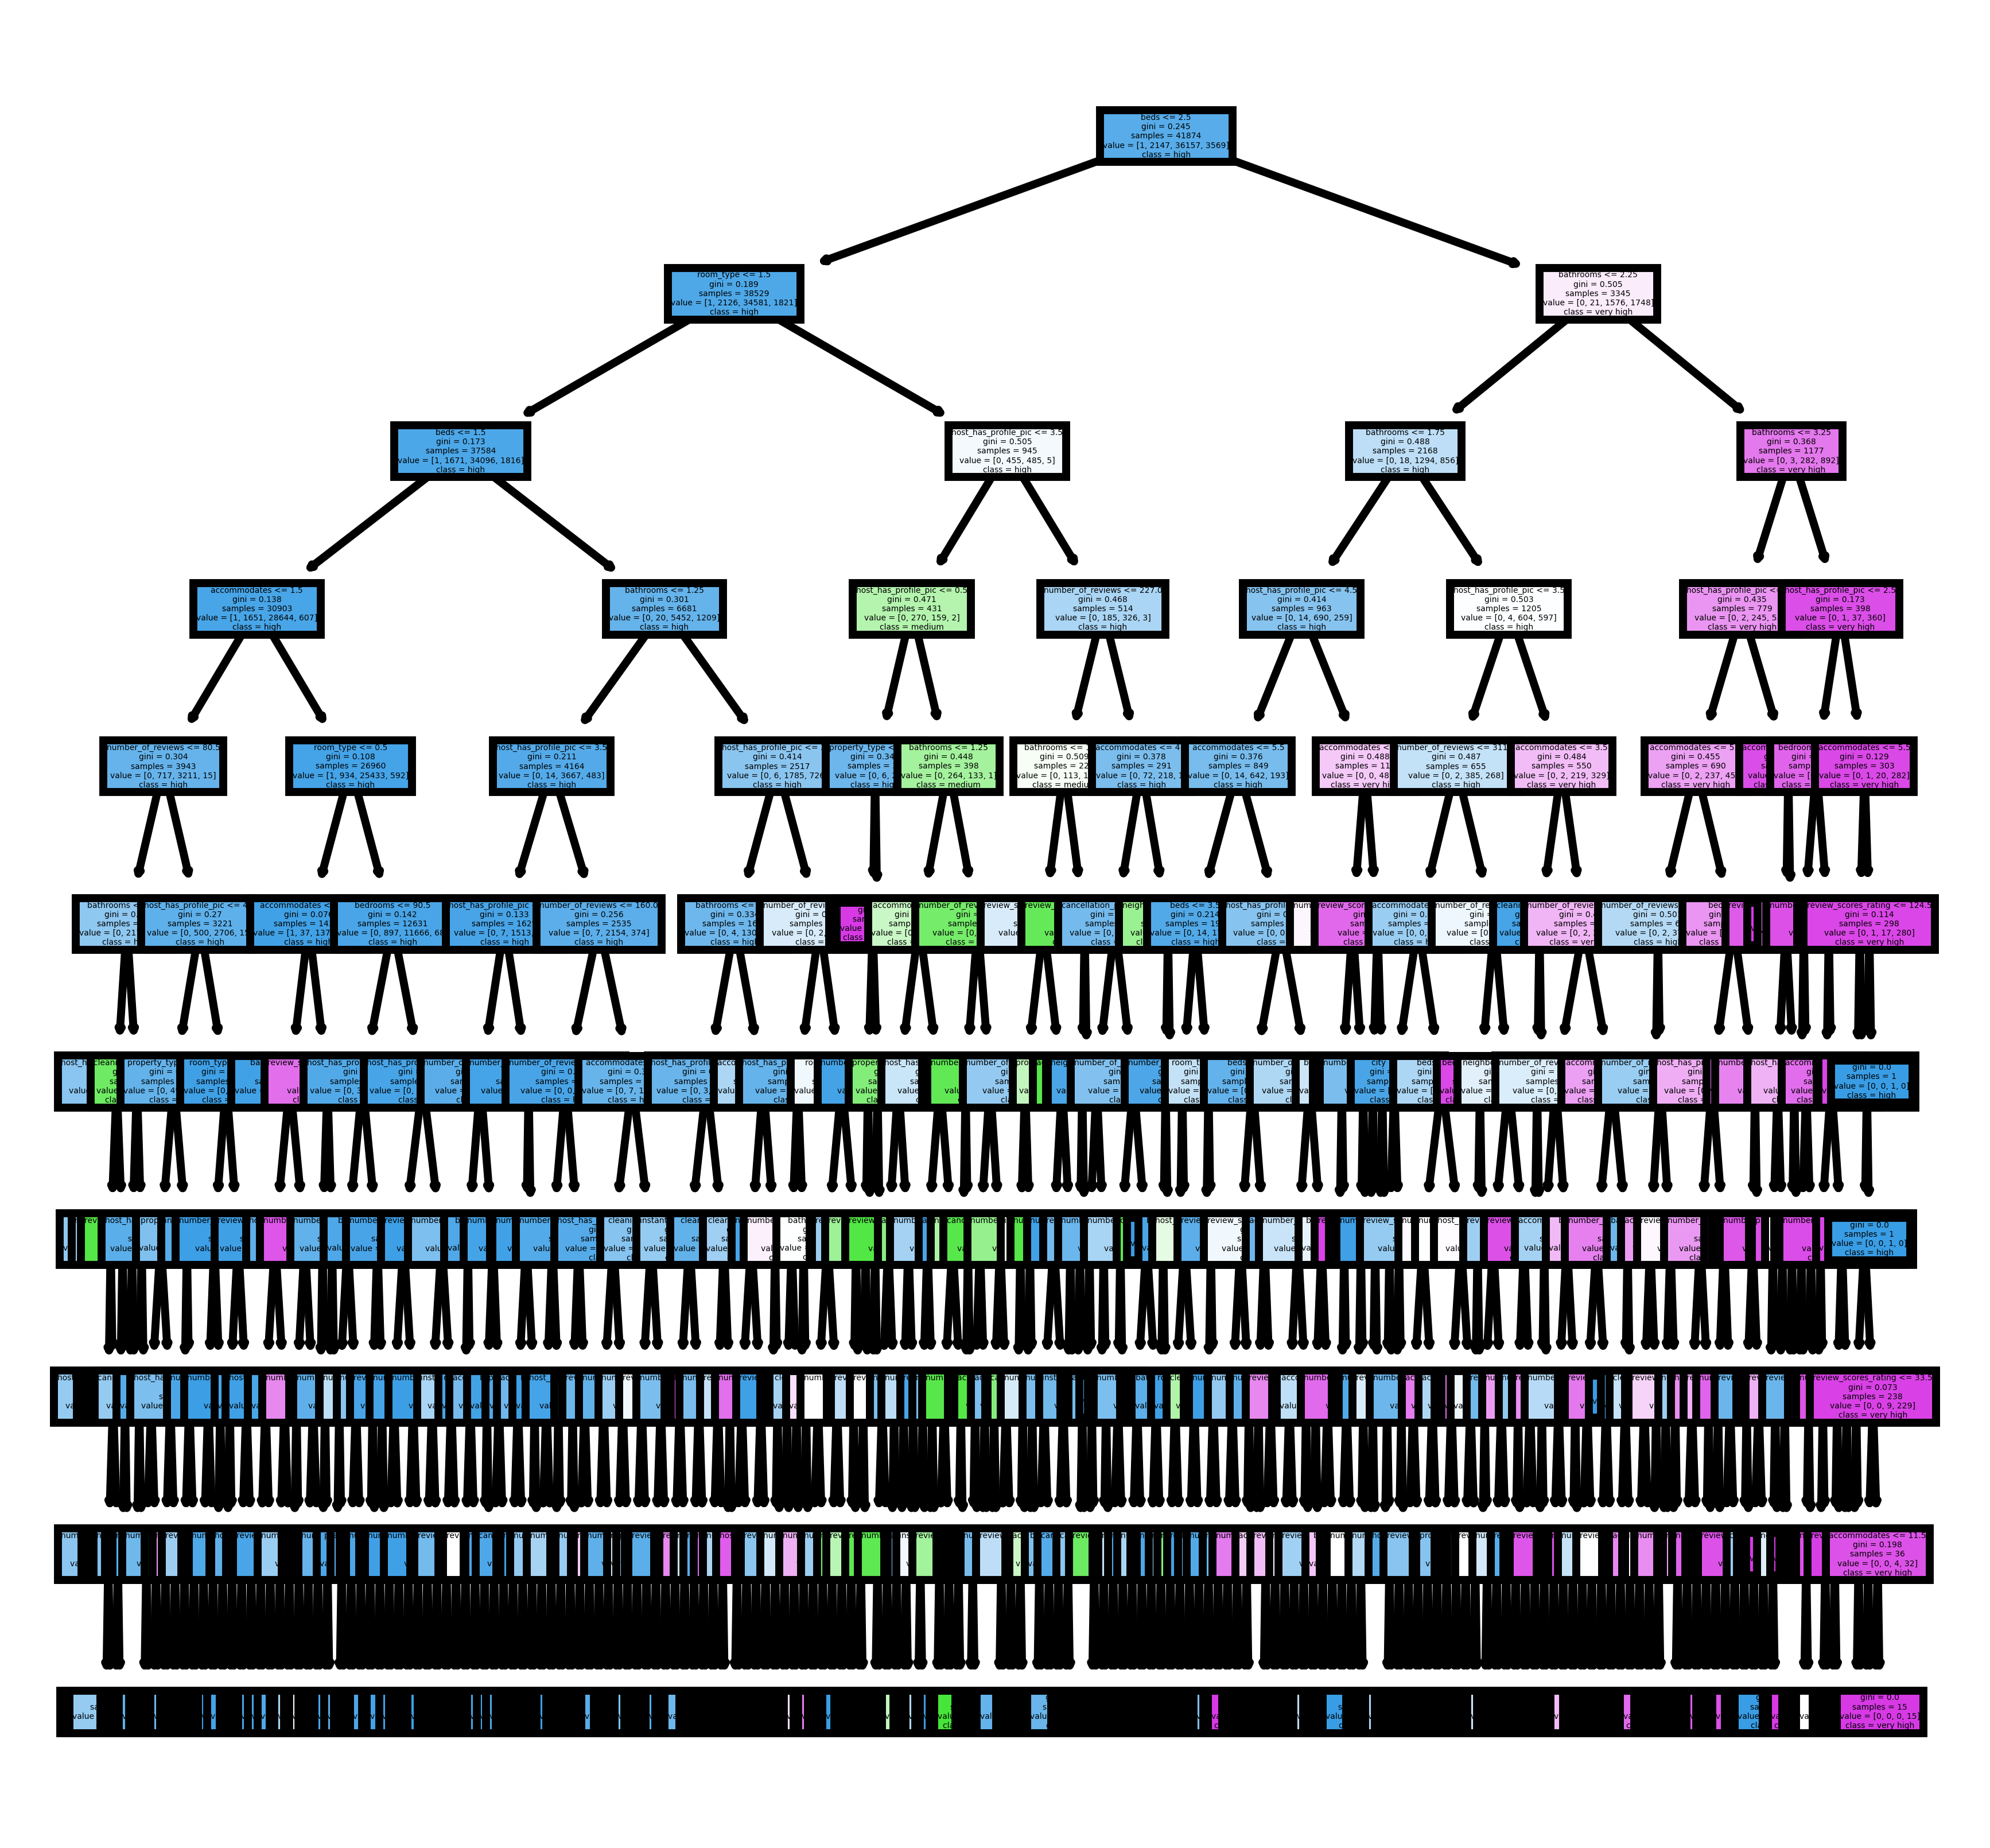

In [122]:
from sklearn import tree
# Create visual tree for train_df
fn=['property_type','room_type','accommodates','bathrooms','cancellation_policy','cleaning_feee','city','host_has_profile_pic','host_identity_verified','instant_bookable','neighbourhood','number_of_reviews','review_scores_rating','bedrooms','beds']
cn=['low', 'medium', 'high', 'very high']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1000)
tree.plot_tree(model,
               feature_names = fn, 
               class_names=cn,
               filled = True);
# fig.savefig('imagename10-train_df.png')

In [123]:
# Random Forest model for train_df
from sklearn.ensemble import RandomForestClassifier 

X = train_df.iloc[:,1:16].values
Y = train_df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
print(cl('X_train shape : {}'.format(X_train.shape)))
print(cl('X_test shape : {}'.format(X_test.shape)))
print(cl('y_train shape : {}'.format(y_train.shape)))
print(cl('y_test shape : {}'.format(y_test.shape)))

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

X_train shape : (41874, 15)
X_test shape : (10469, 15)
y_train shape : (41874,)
y_test shape : (10469,)


RandomForestClassifier()

In [124]:
y_pred=clf.predict(X_test)

In [125]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8900563568631197


In [126]:
# Random Forest model for train10
X = train10.iloc[:,1:12].values
Y = train10.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
print(cl('X_train shape : {}'.format(X_train.shape)))
print(cl('X_test shape : {}'.format(X_test.shape)))
print(cl('y_train shape : {}'.format(y_train.shape)))
print(cl('y_test shape : {}'.format(y_test.shape)))

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

X_train shape : (41874, 11)
X_test shape : (10469, 11)
y_train shape : (41874,)
y_test shape : (10469,)


RandomForestClassifier()

In [127]:
y_pred=clf.predict(X_test)

In [128]:
#accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8889101155793294


In [141]:
# NAIVE BAYES MODELS

#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

X = train_df.iloc[:,1:16].values
Y = train_df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
print(cl('X_train shape : {}'.format(X_train.shape)))
print(cl('X_test shape : {}'.format(X_test.shape)))
print(cl('y_train shape : {}'.format(y_train.shape)))
print(cl('y_test shape : {}'.format(y_test.shape)))

X_train shape : (41874, 15)
X_test shape : (10469, 15)
y_train shape : (41874,)
y_test shape : (10469,)


In [142]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model
gnb.fit(X_train,y_train)

#Predict the response
y_pred = gnb.predict(X_test)

In [143]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0    1    0    0]
 [   0  150  371    0]
 [   0  459 7655  875]
 [   0   10  261  687]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.24      0.29      0.26       521
           3       0.92      0.85      0.89      8989
           4       0.44      0.72      0.55       958

    accuracy                           0.81     10469
   macro avg       0.40      0.46      0.42     10469
weighted avg       0.85      0.81      0.82     10469



C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [144]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8111567484955583


In [145]:
# Naive Bayes model for train10
X = train10.iloc[:,1:12].values
Y = train10.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
print(cl('X_train shape : {}'.format(X_train.shape)))
print(cl('X_test shape : {}'.format(X_test.shape)))
print(cl('y_train shape : {}'.format(y_train.shape)))
print(cl('y_test shape : {}'.format(y_test.shape)))

X_train shape : (41874, 11)
X_test shape : (10469, 11)
y_train shape : (41874,)
y_test shape : (10469,)


In [146]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model
gnb.fit(X_train,y_train)

#Predict the response
y_pred = gnb.predict(X_test)

In [147]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0    1    0    0]
 [   0  149  370    2]
 [   0  381 7901  707]
 [   0    7  316  635]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.28      0.29      0.28       521
           3       0.92      0.88      0.90      8989
           4       0.47      0.66      0.55       958

    accuracy                           0.83     10469
   macro avg       0.42      0.46      0.43     10469
weighted avg       0.85      0.83      0.84     10469



C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [148]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8295921291431846


In [149]:
# improving the model
# define grid search parameters

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [150]:
# tuning the model
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)

print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\nickl\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GaussianNB(var_smoothing=1.0)


In [151]:
y_pred = nbModel_grid.predict(X_test)
print(y_pred)

[3 3 3 ... 3 3 3]


In [152]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   0    0    1    0]
 [   0    0  521    0]
 [   0    0 8989    0]
 [   0    0  958    0]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00       521
           3       0.86      1.00      0.92      8989
           4       0.00      0.00      0.00       958

    accuracy                           0.86     10469
   macro avg       0.21      0.25      0.23     10469
weighted avg       0.74      0.86      0.79     10469



C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nickl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [153]:
# K means clustering models
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
#Define X and Y for train_df
X = train_df.iloc[:,1:16].values
y = train_df.iloc[:,-1].values


In [155]:
# choosing optimal K using SSE/Elbow Plot
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(train_df)
    distortions.append(kmeanModel.inertia_)

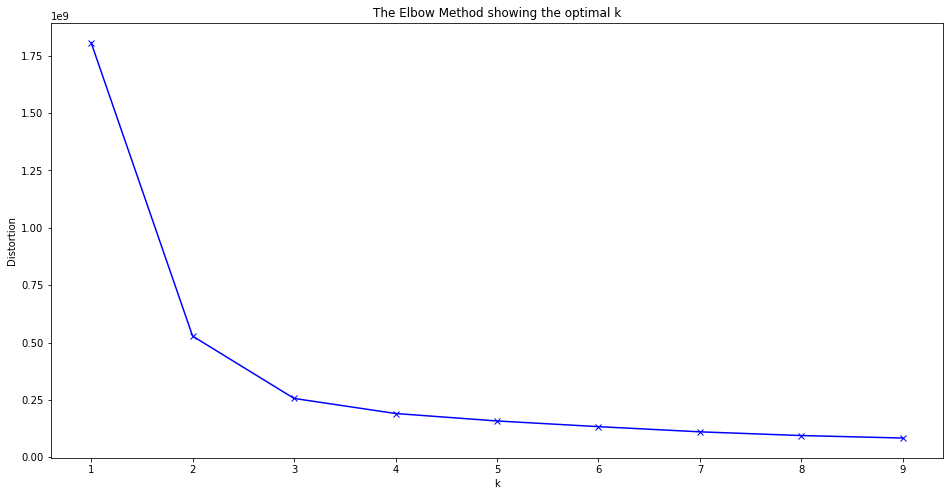

In [156]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [157]:
# build the k means model
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

KMeans(n_clusters=10)

In [158]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(max_iter=600, n_clusters=10, n_jobs=1, precompute_distances='auto')

In [159]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.15270427755382765


In [71]:
# using n_clusters, max_iter and algorithm to tune our model
kmeans = kmeans = KMeans(n_clusters=4, max_iter=1000, algorithm = 'auto')
kmeans.fit(X)

KMeans(max_iter=1000, n_clusters=4)

In [72]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(max_iter=600, n_clusters=4, n_jobs=1, precompute_distances='auto')

In [73]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.1736239802838966


In [74]:
# Scaling the values that are being fed into the model drastically reduces percent correct
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
kmeans.fit(X_scaled)

KMeans(max_iter=1000, n_clusters=4)

In [75]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(max_iter=600, n_clusters=4, n_jobs=1, precompute_distances='auto')

In [76]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.2664921766043215


In [160]:
# Setting X and y model for train10
X = train10.iloc[:,1:12].values
y = train10.iloc[:,-1].values

In [78]:
# choosing optimal K using SSE/Elbow Plot
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(train10)
    distortions.append(kmeanModel.inertia_)

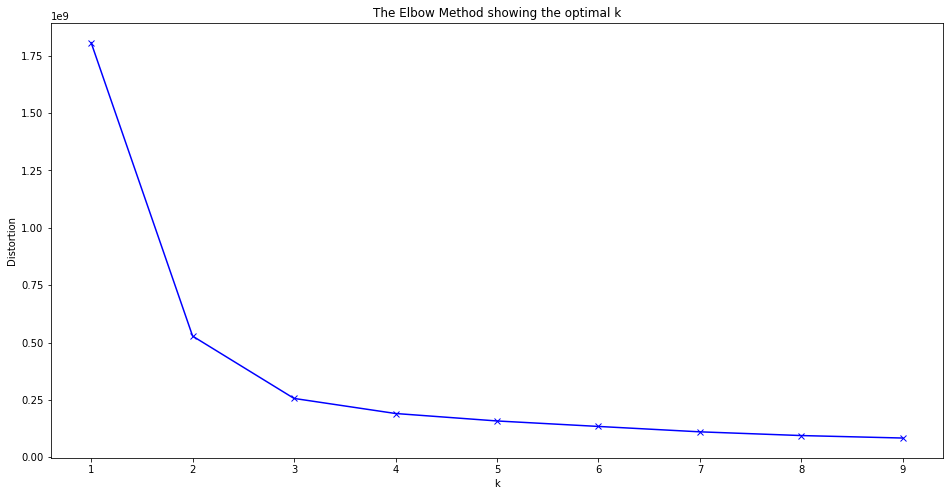

In [79]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [80]:
# build the k means model
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

KMeans(n_clusters=10)

In [81]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(max_iter=600, n_clusters=10, n_jobs=1, precompute_distances='auto')

In [82]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.1150488126397035


In [83]:
# using n_clusters, max_iter and algorithm to tune our model
kmeans = kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
kmeans.fit(X)

KMeans(max_iter=600, n_clusters=4)

In [84]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(max_iter=600, n_clusters=4, n_jobs=1, precompute_distances='auto')

In [85]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.17415891332174313


In [86]:
# Scaling the values that are being fed into the model drastically reduces percent correct
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
kmeans.fit(X_scaled)

KMeans(max_iter=600, n_clusters=4)

In [87]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KMeans(max_iter=600, n_clusters=4, n_jobs=1, precompute_distances='auto')

In [91]:
correct = 0
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == y[i]:
        correct += 1

print(correct/len(X))

0.23922969642550101


In [161]:
# Scaling the data to run hierarchical clustering
from sklearn.preprocessing import normalize
data_scaled = normalize(train_df)
data_scaled = pd.DataFrame(data_scaled, columns=train_df.columns)
data_scaled.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds,price_bins
0,0.040353,0.0,0.000000,0.024160,0.008053,0.032214,0.016107,0.008053,0.032214,0.008053,0.008053,0.000000,0.587905,0.016107,0.805350,0.008053,0.008053,0.024160
1,0.019832,0.0,0.000000,0.027062,0.003866,0.015464,0.007732,0.003866,0.015464,0.003866,0.000000,0.003866,0.931702,0.023196,0.359536,0.011598,0.011598,0.011598
2,0.019544,0.0,0.000000,0.019636,0.003927,0.015709,0.003927,0.003927,0.015709,0.003927,0.003927,0.003927,0.930738,0.039272,0.361299,0.003927,0.011781,0.011781
3,0.039787,0.0,0.000000,0.016770,0.008385,0.033541,0.008385,0.008385,0.016770,0.008385,0.008385,0.008385,0.939139,0.033541,0.335407,0.000000,0.008385,0.025156
4,0.011472,0.0,0.002582,0.005164,0.002582,0.010329,0.005164,0.002582,0.012911,0.002582,0.002582,0.002582,0.965758,0.007747,0.258224,0.002582,0.002582,0.007747


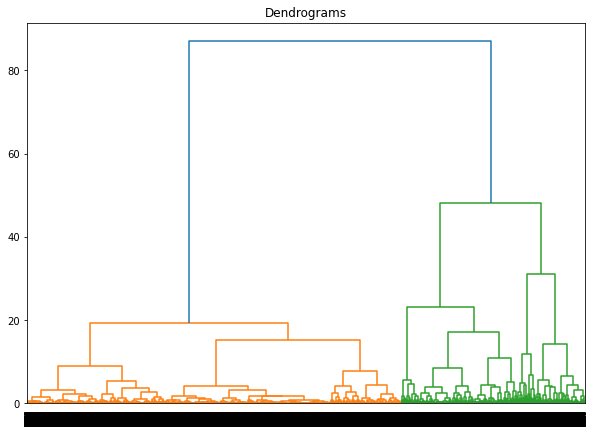

In [162]:
# run the model and plot the dendograms
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [163]:
# clustering the model based on 2 clusters
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(data_scaled)

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

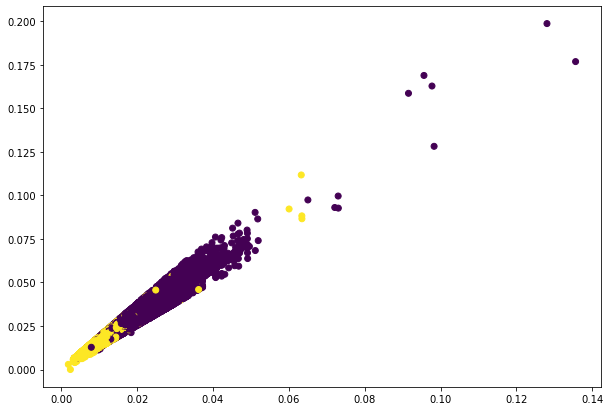

In [164]:
# plotting price_brins vs log_price clusters
plt.figure(figsize=(10, 7))  
plt.scatter(data_scaled['price_bins'], data_scaled['log_price'], c=cluster.labels_) 